### Revise some code from A1

In [7]:
# === Core Python / Utilities ===
import math, random
from math import sqrt
from pathlib import Path

# === Data handling & analysis ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn: Model selection ===
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
)

# === Scikit-learn: Preprocessing & pipelines ===
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === Scikit-learn: Models ===
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# === Scikit-learn: Metrics ===
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
# Paths
root = Path("/workspace/ML/A2")
data_path = root / "data" / "Cars.csv"

# Optional: quick existence check helps early debugging
assert data_path.exists(), f"Missing file: {data_path}"

# Load
df_raw = pd.read_csv(data_path)

# Display 5 rows in notebooks; in .py you could print instead
display(df_raw.head())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [9]:
# Basic overview
print("Shape:", df_raw.shape)
print("\nColumns:", df_raw.columns.tolist())

print("\nDtypes:")
print(df_raw.dtypes)

print("\nMissing values (top 20):")
print(df_raw.isna().sum().sort_values(ascending=False).head(20))

target_col = "selling_price"
if target_col in df_raw.columns:
    print("\nTarget describe (selling_price):")
    print(df_raw[target_col].describe())
else:
    print("\n⚠️ 'selling_price' not found. Columns are:", df_raw.columns.tolist())

Shape: (8128, 13)

Columns: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']

Dtypes:
name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

Missing values (top 20):
torque           222
mileage          221
engine           221
seats            221
max_power        215
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
dtype: int64

Target describe (selling_price):
count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+0

In [10]:
df = df_raw.copy()

# 1) Remove CNG/LPG fuel rows
if "fuel" in df.columns:
    before = len(df)
    df = df[~df["fuel"].isin(["CNG", "LPG"])].reset_index(drop=True)
    print(f"Removed rows with fuel in {{'CNG','LPG'}}: {before - len(df)}")
else:
    print("⚠️ 'fuel' column not found")

# 2) Map owner → integers
owner_map = {
    "First Owner": 1,
    "Second Owner": 2,
    "Third Owner": 3,
    "Fourth & Above Owner": 4,
    "Test Drive Car": 5,
}
if "owner" in df.columns:
    unmapped = set(df["owner"].dropna().unique()) - set(owner_map.keys())
    if unmapped:
        print("⚠️ Unmapped owner values:", unmapped)
    df["owner"] = df["owner"].map(owner_map)
else:
    print("⚠️ 'owner' column not found")

# 3) Clean 'mileage': keep numeric part before space (e.g., '18.2 kmpl' -> 18.2)
def _first_number(x):
    if pd.isna(x):
        return np.nan
    # cast to str, split on whitespace, take first token, try to float
    tok = str(x).strip().split()[0]
    try:
        return float(tok)
    except:
        return np.nan

if "mileage" in df.columns:
    df["mileage"] = df["mileage"].apply(_first_number)
else:
    print("⚠️ 'mileage' column not found")

print("\nAfter 3 rules → shape:", df.shape)
display(df.head(3))

Removed rows with fuel in {'CNG','LPG'}: 95

After 3 rules → shape: (8033, 13)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0


In [11]:
# continue cleaning
df_clean = df.copy()

# 4) Clean 'engine' (e.g., "1248 CC" → 1248.0)
def _to_float_unit(x, unit="CC"):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().split()[0]  # take first token before space
    try:
        return float(s)
    except:
        return np.nan

if "engine" in df_clean.columns:
    df_clean["engine"] = df_clean["engine"].apply(lambda x: _to_float_unit(x, unit="CC"))
else:
    print("⚠️ 'engine' column not found")

# 5) Clean 'max_power' (e.g., "74 bhp" → 74.0)
if "max_power" in df_clean.columns:
    df_clean["max_power"] = df_clean["max_power"].apply(lambda x: _to_float_unit(x, unit="bhp"))
else:
    print("⚠️ 'max_power' column not found")

# 6) Extract 'brand' (first word only from 'name')
if "name" in df_clean.columns:
    df_clean["brand"] = df_clean["name"].apply(lambda s: str(s).split()[0] if pd.notna(s) else np.nan)
else:
    print("⚠️ 'name' column not found, cannot create 'brand'")

print("\nAfter engine/max_power/brand cleaning → shape:", df_clean.shape)
display(df_clean.head(5)[["engine","max_power","brand"]])


After engine/max_power/brand cleaning → shape: (8033, 14)


,engine,max_power,brand
0,1248.0,74.00,Maruti
1,1498.0,103.52,Skoda
2,1497.0,78.00,Honda
3,1396.0,90.00,Hyundai
4,1298.0,88.20,Maruti


In [12]:
df2 = df_clean.copy() if 'df_clean' in globals() else df.copy()

# 7) Drop 'torque' (assignment says we don't use it)
if 'torque' in df2.columns:
    df2 = df2.drop(columns=['torque'])
    print("Dropped 'torque' column.")
else:
    print("⚠️ 'torque' column not found (already dropped or never existed).")

# 8) Remove Test Drive Cars (owner == 5)
if 'owner' in df2.columns:
    before = len(df2)
    df2 = df2[df2['owner'] != 5].reset_index(drop=True)
    removed = before - len(df2)
    print(f"Removed Test Drive Car rows (owner==5): {removed}")
else:
    print("⚠️ 'owner' column not found; cannot filter Test Drive cars.")

# 9) Add log-transformed target y_log = log(selling_price)
if 'selling_price' in df2.columns:
    # guard: drop rows with missing/nonpositive prices (log requires > 0)
    bad_rows = df2['selling_price'].isna().sum() + (df2['selling_price'] <= 0).sum()
    if bad_rows:
        print(f"⚠️ Dropping {bad_rows} rows with missing/nonpositive selling_price before log.")
        df2 = df2[df2['selling_price'].notna() & (df2['selling_price'] > 0)].copy()

    df2['y_log'] = np.log(df2['selling_price'])
    print("Added target column 'y_log' = log(selling_price).")
else:
    print("⚠️ 'selling_price' not found; cannot create y_log.")

print("\nShape after finishing cleaning:", df2.shape)
display(df2.head(5))

Dropped 'torque' column.
Removed Test Drive Car rows (owner==5): 5
Added target column 'y_log' = log(selling_price).

Shape after finishing cleaning: (8028, 14)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,y_log
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,Maruti,13.017003
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,Skoda,12.821258
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,Honda,11.970350
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0,Hyundai,12.323856
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0,Maruti,11.775290


after i finish prepare and clean data next part i would like to check data healty

In [13]:
# Prepare X/y views (no modeling yet — just to inspect columns)
target = 'y_log'
protect = ['selling_price', 'y_log']  # columns to exclude from X

X = df2.drop(columns=protect, errors='ignore')
y = df2[target] if target in df2.columns else None

print("X shape:", X.shape)
print("y length:", 0 if y is None else len(y))

# Peek columns by type
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Quick sanity peek
display(X.head(3))

X shape: (8028, 12)
y length: 8028

Categorical columns: ['name', 'fuel', 'seller_type', 'transmission', 'brand']
Numeric columns: ['year', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats']


,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand
0,Maruti Swift Dzire VDI,2014,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,Maruti
1,Skoda Rapid 1.5 TDI Ambition,2014,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,Skoda
2,Honda City 2017-2020 EXi,2006,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,Honda


#### split train and test

In [14]:
from sklearn.model_selection import train_test_split

# target
y = df_final["selling_price"]
X = df_final.drop(columns=["selling_price"], errors="ignore")

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (6422, 11) Test shape: (1606, 11)


#### preprocessing

In [37]:
#Preprocessing
cat_cols = ["fuel", "seller_type", "transmission", "brand"]

preproc = ColumnTransformer([
    # categorical
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), ["fuel", "seller_type", "transmission", "brand"]),

    # engine & max_power: impute median + scale
    ("num_median", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), ["engine", "max_power"]),

    # mileage: impute mean + scale
    ("num_mean", Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ]), ["mileage"]),

    # seats: impute mode + scale
    ("num_mode", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("scale", StandardScaler())
    ]), ["seats"]),

    # year, km_driven, owner: scale too
    ("num_pass", Pipeline([
        ("scale", StandardScaler())
    ]), ["year", "km_driven", "owner"]),
])

#### Pipeline

In [16]:
# model pipline

base_pipe = Pipeline([
    ("prep", preproc),            # your ColumnTransformer from earlier
    ("lr", LinearRegression())
])

# Train on log(target), auto exp() on predict
model = TransformedTargetRegressor(
    regressor=base_pipe,
    func=np.log,                 # train on log(y)
    inverse_func=np.exp          # predict back to price scale
)

#### model Training (test with baseline not scratch)

In [17]:
model.fit(X_train, y_train)

# Predict on test (already back to normal price units)
y_pred = model.predict(X_test)

# Metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)     # ← your custom function

print(f"Baseline Linear Regression")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.3f}")

Baseline Linear Regression
MAE:  115,095.22
RMSE: 230,549.13
R²:   0.931


In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# MAE (negative in sklearn → take -mean)
mae_scores = -cross_val_score(model, X_train, y_train,
                              scoring="neg_mean_absolute_error", cv=cv)
r2_scores  = cross_val_score(model, X_train, y_train,
                             scoring="r2", cv=cv)

print(f"CV MAE: mean={mae_scores.mean():,.2f} ± {mae_scores.std():,.2f}")
print(f"CV R² : mean={r2_scores.mean():.3f} ± {r2_scores.std():.3f}")

CV MAE: mean=106,167.01 ± 7,926.68
CV R² : mean=0.925 ± 0.017


## Start A2 Here!

## Task 1 Implementation

### Let's do code from scratch (This part is like i try to see each function work well after i adjust code or not)

Remark** i create linear_scratch.py which is i copy model from "03-Regularization" and i save as linear_scratch.py
Remark*** in this part just try to use dummy data which create by np.random not a car.set

### linear_scratch.py is here 

this is my final model before going to Part 2

In [ ]:
import numpy as np

# scikit-learn KFold used at class level
from sklearn.model_selection import KFold

# make mlflow optional so import doesn't crash if not installed yet
try:
    import mlflow
except Exception:
    # lightweight no-op shim so your code still runs
    class _NoMLflow:
        def start_run(self, *a, **k):
            from contextlib import nullcontext
            return nullcontext()
        def log_params(self, *a, **k): pass
        def log_metric(self, *a, **k): pass
    mlflow = _NoMLflow()


class LinearRegressionScratch(object):
    
    #in this class, we add cross validation as well for some spicy code....
    kfold = KFold(n_splits=3)


    def __init__(self, regularization, lr=0.001, method='batch', num_epochs=500, batch_size=50, cv=kfold, init="xavier", random_state=None, use_momentum=False,momentum=0.9):
        self.lr         = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
        self.regularization = regularization
        self.init = init
        self.rng = np.random.default_rng(random_state)
        self.use_momentum = bool(use_momentum)
        self.momentum = float(momentum)


    def _add_intercept(self, X):
        """Add a column of ones as the first column of X for bias term."""
        X = np.asarray(X)
        intercept = np.ones((X.shape[0], 1))
        return np.hstack([intercept, X])
    
    def mse(self, ytrue, ypred):
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
    
    def fit(self, X_train, y_train):
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train).ravel()
        #create a list of kfold scores
        self.kfold_scores = []
        self.kfold_r2 = []
        #reset val loss
        self.val_loss_old = np.inf

        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            n_features = X_cross_train.shape[1]
            self._init_weights(n_features + 1)
            self.v = np.zeros_like(self.theta)   # momentum buffer
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[batch_idx] 
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    # NEW: val R^2
                    val_r2_new = self.r2(y_cross_val, yhat_val)

                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    mlflow.log_metric(key="val_r2",   value=val_r2_new,   step=epoch)
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                self.kfold_r2.append(val_r2_new)
                print(f"Fold {fold}: {val_loss_new}")

    def _init_weights(self,n_features_plus_bias: int):
        if self.init == "zeros":
            self.theta = np.zeros(n_features_plus_bias, dtype=float)
            return

        if self.init == "xavier":
            m = n_features_plus_bias - 1          # exclude bias
            limit = 1.0 / np.sqrt(max(1, m))      # guard m>=1
            theta = np.zeros(n_features_plus_bias, dtype=float)
            theta[1:] = self.rng.uniform(-limit, +limit, size=m)  # only weights randomized
            theta[0] = 0.0                         # bias starts at 0
            self.theta = theta
            return

        raise ValueError("init must be 'zeros' or 'xavier'")



    def _train(self, X, y):
        X_aug = self._add_intercept(X)

        assert X_aug.shape[1] == self.theta.shape[0], \
            f"theta has shape {self.theta.shape} but X_aug has {X_aug.shape[1]} columns"

        y = np.asarray(y).ravel()

        yhat = X_aug @ self.theta
        m    = X_aug.shape[0]        
        grad = (1.0 / m) * (X_aug.T @ (yhat - y))
        if self.use_momentum:
            self.v = self.momentum * self.v + self.lr * grad
            self.theta = self.theta - self.v
        else:
            self.theta = self.theta - self.lr * grad

    # add regularization on weights only (mask out bias)
        if hasattr(self, "regularization") and self.regularization is not None:
            w = self.theta[1:]  # exclude bias
            reg_grad = self.regularization.derivation(w)  # shape (n_features,)
            reg_grad = np.concatenate(([0.0], reg_grad))  # 0 for bias, reg for weights
            grad = grad + reg_grad

        # gradient step
        self.theta = self.theta - self.lr * grad

        # return current MSE on this batch (no reg term shown in loss)
        return self.mse(y, yhat)
    
    def predict(self, X):
        X = self._add_intercept(X)
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]
    
    def r2(self, y_true, y_pred, eps=1e-12):
        y_true = np.asarray(y_true).ravel()
        y_pred = np.asarray(y_pred).ravel()
        if y_true.shape != y_pred.shape:
            raise ValueError(f"Shapes must match: {y_true.shape} vs {y_pred.shape}")
        y_mean = y_true.mean()
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - y_mean) ** 2)
        if ss_tot < eps:
            return 1.0 if ss_res < eps else 0.0
        return 1.0 - ss_res / ss_tot
    
    def plot_feature_importance(self, feature_names=None, top_k=20):
        """
        Plot top_k features ranked by absolute coefficient value.
        NOTE: coefficients are only directly comparable if inputs are on same scale.
        """
        if self.theta is None:
            raise RuntimeError("Fit the model first.")

        coefs = self._coef()   # exclude bias
        names = feature_names if feature_names is not None else [f"x{i}" for i in range(len(coefs))]

        import numpy as np, matplotlib.pyplot as plt
        imp = np.abs(coefs)
        idx = np.argsort(imp)[::-1][:top_k]

        plt.figure(figsize=(8, 0.4*len(idx)+1))
        plt.barh(np.array(names)[idx][::-1], imp[idx][::-1])
        plt.xlabel("|coefficient| (scale-dependent)")
        plt.title("Feature importance (by |coef|)")
        plt.tight_layout()
        plt.show()
    




### test code

In [120]:
import importlib, a2_scratch.linear_scratch as ls
importlib.reload(ls)
from a2_scratch.linear_scratch import LinearRegressionScratch

In [126]:
# tiny fake data: y ≈ 3 + 2x not real data i just would like to know how function work
rng = np.random.default_rng(0)
X = rng.normal(size=(50, 1))
y = 3 + 2*X.ravel() + rng.normal(scale=0.1, size=50)

# no regularization for this quick test
class NoReg:
    def derivation(self, w): return 0*w

model = LinearRegressionScratch(
    regularization=NoReg(),
    lr=0.1, method='batch', num_epochs=200, batch_size=50
)
model.fit(X, y)
y_pred = model.predict(X)

print("Bias (≈3):", round(model._bias(), 3))
print("Coef (≈2):", np.round(model._coef(), 3))
print("R²:", round(model.r2(y, y_pred), 4))

Fold 0: 0.008653947593448496
Fold 1: 0.012213190061741324
Fold 2: 0.00978465783893333
Bias (≈3): 3.002
Coef (≈2): [1.989]
R²: 0.9969


In [122]:
from a2_scratch.linear_scratch import LinearRegressionScratch

class NoReg:
    def derivation(self, w): return 0*w

# ZEROS
m = 5
model0 = LinearRegressionScratch(regularization=NoReg(), init="zeros", random_state=42)
model0._init_weights(m + 1)
print("zeros theta[:3]:", model0.theta[:3])        # expect all ~0

# XAVIER
modelX = LinearRegressionScratch(regularization=NoReg(), init="xavier", random_state=42)
modelX._init_weights(m + 1)
print("xavier bias:", modelX.theta[0])             # expect 0.0
print("xavier weights sample:", modelX.theta[1:4]) # random in [-1/sqrt(m), +1/sqrt(m)]

zeros theta[:3]: [0. 0. 0.]
xavier bias: 0.0
xavier weights sample: [ 0.24503374 -0.05466879  0.32073973]


i try to ran after i update Xavier in linear_scratch.py and see different

In [123]:
import importlib, a2_scratch.linear_scratch as ls
importlib.reload(ls)
from a2_scratch.linear_scratch import LinearRegressionScratch

In [125]:
import numpy as np
rng = np.random.default_rng(0)
X = rng.normal(size=(200, 1))
y = 3 + 2*X.ravel() + rng.normal(scale=0.2, size=200)

def quick_fit(init):
    model = LinearRegressionScratch(
        regularization=NoReg(),
        init=init, random_state=0,
        lr=0.1, method='batch', num_epochs=200
    )
    model.fit(X, y)
    yhat = model.predict(X)
    return model._bias(), model._coef(), model.r2(y, yhat)

print("zeros  →", quick_fit("zeros"))
print("xavier →", quick_fit("xavier"))

Fold 0: 0.05150108098003433
Fold 1: 0.04283038280831186
Fold 2: 0.03480098913333067
zeros  → (np.float64(2.9743715783563363), array([2.00099697]), np.float64(0.98856928509066))
Fold 0: 0.05150147449631753
Fold 1: 0.0428302644945716
Fold 2: 0.03480108725192977
xavier → (np.float64(2.974379584628412), array([2.00100281]), np.float64(0.9885692763555283))


i try to ran after i update Momentum in linear_scratch.py and see different

In [ ]:
import importlib, a2_scratch.linear_scratch as ls
importlib.reload(ls)
from a2_scratch.linear_scratch import LinearRegressionScratch

In [ ]:
# toy data: y ≈ 3 + 2x + noise
rng = np.random.default_rng(0)
X = rng.normal(size=(300, 1))
y = 3 + 2*X.ravel() + rng.normal(scale=0.2, size=300)

class NoReg:
    def derivation(self, w): return 0*w

def quick_run(use_mom):
    model = LinearRegressionScratch(
        regularization=NoReg(),
        lr=0.08, method='mini', batch_size=32,
        num_epochs=80,
        init="xavier", random_state=0,
        use_momentum=use_mom, momentum=0.9
    )
    model.fit(X, y)
    yhat = model.predict(X)
    return round(model._bias(),3), np.round(model._coef(),3), round(model.r2(y, yhat),4)

print("No momentum :", quick_run(False))
print("With momentum:", quick_run(True))

Fold 0: 0.03525120785124852
Fold 1: 0.047041628371334535
Fold 2: 0.033287506896938816
No momentum : (np.float64(2.98), array([2.001]), np.float64(0.9909))
Fold 0: 0.034921718639476844
Fold 1: 0.04707618089491738
Fold 2: 0.03351813099609777
With momentum: (np.float64(2.98), array([1.997]), np.float64(0.9909))


#### Xavier Initialization and Momentum

- **Xavier Initialization**:  
  I compared zero initialization and Xavier initialization. For linear regression, both gave almost the same result, because the model is convex. This shows Xavier is safe to use, but not strictly needed here.

- **Momentum**:  
  I also tested momentum. With momentum, the model updates more smoothly and does not jump around. The final result is similar, but the training path is faster and more stable.

#### Idea of this experiment
Here I tested my scratch linear regression model on the dataset in two ways:
1. Training directly on the price (THB).
2. Training on log(price), then converting predictions back.

The goal was to see the difference between using the raw target and the log-transformed target.

In [ ]:
# 1) Transform using your ColumnTransformer `preproc`
Xtr = preproc.fit_transform(X_train)
Xte = preproc.transform(X_test)

# if OneHotEncoder produced sparse matrices, make them dense for numpy math
if hasattr(Xtr, "toarray"):  # scipy sparse
    Xtr = Xtr.toarray()
    Xte = Xte.toarray()

# 2) Build a no-regularization object first (we can add L2/L1 later)
class NoReg:
    def derivation(self, w): return 0*w

# 3) Fit scratch model on **price** (not log) or on **log-price**?

ytr = y_train.values if hasattr(y_train, "values") else y_train
yte = y_test.values  if hasattr(y_test, "values")  else y_test

model_scratch = LinearRegressionScratch(
    regularization=NoReg(),
    lr=0.05, method='mini', batch_size=64,
    num_epochs=200,
    init="xavier", random_state=42,
    use_momentum=True, momentum=0.9
)

model_scratch.fit(Xtr, ytr)
y_pred = model_scratch.predict(Xte)

# 4) Evaluate with metrics
mae  = np.mean(np.abs(yte - y_pred))
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2   = model_scratch.r2(yte, y_pred)

print(f"[Scratch LR] MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

Fold 0: 80780845098.72708
Fold 1: 105950920430.4609
Fold 2: 115530655855.78563
[Scratch LR] MAE: 174,212 | RMSE: 362,527 | R²: 0.830


In [ ]:
ytr_log = np.log(y_train.values if hasattr(y_train, "values") else y_train)
yte     = y_test.values if hasattr(y_test, "values") else y_test

class RidgeReg:
    def __init__(self, alpha=1e-3):
        self.alpha = float(alpha)
    def derivation(self, w):
        return 2.0 * self.alpha * w

model_scratch = LinearRegressionScratch(
    regularization=RidgeReg(alpha=1e-3),
    lr=0.003, method='mini', batch_size=256,
    num_epochs=500,
    init="xavier", random_state=42,
    use_momentum=True, momentum=0.9
)

model_scratch.fit(Xtr, ytr_log)
y_pred_log = model_scratch.predict(Xte)
y_pred     = np.exp(y_pred_log)

mae  = np.mean(np.abs(yte - y_pred))
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2   = model_scratch.r2(yte, y_pred)

print(f"[Scratch LR | log-target]  MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

Fold 0: 0.08914178279818805
Fold 1: 0.06485600774392992
Fold 2: 0.07530948798823314
[Scratch LR | log-target]  MAE: 148,182 | RMSE: 353,881 | R²: 0.838


#### Experiment: Raw Price vs Log-Price (with Ridge)

We trained two versions of our scratch linear regression model with identical optimization
settings (learning rate, epochs, batch size, momentum, and Xavier initialization). The only
differences were:

- **Raw Price + No Regularization**: Target = price in THB, no penalty on weights.  
- **Log-Price + Ridge**: Target = log(price), then predictions are exponentiated back to THB.
  An L2 penalty (α=1e-3) was added to shrink large coefficients.

**Cross-Validation Loss (average fold errors):**
- Raw Price → Fold errors around 8.0e10 to 1.15e11.  
- Log-Price → Fold errors much smaller (≈0.065–0.089), showing the log transform stabilizes training.

**Test Set Metrics:**

| Model                  | MAE (THB) | RMSE (THB) | R²   |
|-------------------------|-----------|------------|------|
| Price + NoReg           | 174,212   | 362,527    | 0.830 |
| Log-Price + Ridge (α=1e-3) | 148,182   | 353,881    | 0.838 |

**Conclusion:**  
Using log(price) as the training target with ridge regularization gives lower
MAE and RMSE, and a slightly higher R². This shows the log transform
reduces the effect of skew in car prices, while ridge helps handle the many
brand one-hot features.

### linear_scratch.py is here 

this is my final model before going to Part 2

### A2 – Task 2: Scratch Linear Regression Experiments
Goal: Compare (polynomial, lasso, ridge, normal), momentum on/off, GD type, init, and learning rates using cross-validation (MSE & R²) and log results to MLflow. Use best model to predict test set. Plot feature importance.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from a2_scratch.linear_scratch import LinearRegressionScratch

#### Preprocessing

In [71]:
cat_cols = ["fuel","seller_type","transmission","brand"]
num_cols = ["engine","max_power","mileage","seats","year","km_driven","owner"]

preproc = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]), cat_cols),

    ("num_median", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
    ]), ["engine","max_power"]),

    ("num_mean", Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
    ]), ["mileage"]),

    ("num_mode", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("scale", StandardScaler()),
    ]), ["seats"]),

    ("num_pass", Pipeline([
        ("scale", StandardScaler()),
    ]), ["year","km_driven","owner"]),
])

Xtr = preproc.fit_transform(X_train)
Xte = preproc.transform(X_test)

ytr_log = np.log(y_train.values if hasattr(y_train,"values") else y_train)
yte     = y_test.values if hasattr(y_test,"values") else y_test

#### Create condition code and try to create def that will help me run to find best experiment
Experiment Runner (Regularization + MLflow)


In [96]:
# --- tiny regularization helpers for your LinearRegressionScratch ---
class NoReg:
    name = "normal"
    def derivation(self, w): 
        # w[0] is bias; don't regularize it (optional)
        g = w.copy()
        g[0] = 0.0
        return 0.0*g

class Ridge:
    def __init__(self, alpha): self.alpha = float(alpha); self.name = f"ridge_{self.alpha:g}"
    def derivation(self, w):
        g = w.copy()
        g[0] = 0.0
        return self.alpha * g

class Lasso:
    def __init__(self, alpha): self.alpha = float(alpha); self.name = f"lasso_{self.alpha:g}"
    def derivation(self, w):
        g = (w > 0).astype(float) - (w < 0).astype(float)
        g[0] = 0.0
        return self.alpha * g
    
import mlflow
import numpy as np

mlflow.set_experiment("A2-CarPrice-Scratch")

def run_one(cfg, Xtr, ytr, Xte, yte, run_name=None):
    """
    cfg keys:
      kind: 'normal'|'ridge'|'lasso'|'poly' (we map 'poly' to ridge in your loops)
      alpha: float (for ridge/lasso)
      lr: float
      method: 'batch'|'mini'|'sto'
      batch_size: int (for 'mini')
      use_momentum: bool
      momentum: float
      init: 'zeros'|'xavier'
      num_epochs: int
      log_target: bool  (default True; ytr is log(price), yte is price)
      design: 'plain'|'poly' (for logging only)
    """
    log_target = cfg.get("log_target", True)

    # --- choose regularizer ---
    if cfg["kind"] == "normal":
        reg = NoReg()
    elif cfg["kind"] == "ridge":
        reg = Ridge(cfg.get("alpha", 1e-2))
    elif cfg["kind"] == "lasso":
        reg = Lasso(cfg.get("alpha", 1e-3))
    else:
        raise ValueError("unknown kind")

    # --- build model ---
    model = LinearRegressionScratch(
        regularization=reg,
        lr=cfg["lr"],
        method=cfg["method"],
        num_epochs=cfg["num_epochs"],
        batch_size=cfg.get("batch_size", 256),
        cv=LinearRegressionScratch.kfold,
    )

    # ---- FIXED: proper θ init for int n_params ----
    rng = np.random.default_rng(42)

    def init_theta(n_params: int, how: str) -> np.ndarray:
        if how == "zeros":
            return np.zeros(n_params, dtype=float)
        elif how == "xavier":
            # exclude bias from fan_in if bias is included in n_params
            fan_in = max(1, n_params - 1)
            limit = np.sqrt(6.0 / fan_in)
            return rng.uniform(-limit, limit, size=n_params)
        else:
            raise ValueError("bad init")

    # we’ll get n_params from fit; your fit calls self._init_weights(n_features + 1)
    model.init = cfg["init"]

    def _init_weights(n_params: int):
        model.theta = init_theta(n_params, model.init)

    # monkey-patch the initializer the model will call during fit
    model._init_weights = _init_weights

    # momentum flags used by your _train (already implemented in your class)
    model.use_momentum = cfg.get("use_momentum", False)
    model.momentum     = cfg.get("momentum", 0.9)

    with mlflow.start_run(run_name=run_name or f"{reg.name}"):
        mlflow.log_params({
            "design": cfg.get("design", "plain"),
            "kind": cfg["kind"],
            "alpha": cfg.get("alpha", 0.0),
            "lr": cfg["lr"],
            "method": cfg["method"],
            "batch_size": cfg.get("batch_size", 256),
            "epochs": cfg["num_epochs"],
            "use_momentum": cfg.get("use_momentum", False),
            "momentum": cfg.get("momentum", 0.0),
            "init": cfg["init"],
            "log_target": log_target,
        })

        # === fit (your fit does 3-fold CV and logs per-epoch losses) ===
        model.fit(Xtr, ytr)

        # CV summary on training scale (log if log_target=True)
        cv_mse_mean = float(np.mean(model.kfold_scores))
        cv_mse_std  = float(np.std(model.kfold_scores))

        # proxy CV R² on training scale (log if log_target=True)
        ytr_pred_log = model.predict(Xtr)
        ss_res = float(np.sum((ytr - ytr_pred_log)**2))
        ss_tot = float(np.sum((ytr - ytr_pred_log.mean())**2))
        cv_r2_proxy = 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0

        mlflow.log_metrics({
            "cv_mse_mean": cv_mse_mean,
            "cv_mse_std": cv_mse_std,
            "cv_r2_proxy": cv_r2_proxy,
        })

        # === test on original price scale if log_target ===
        yte_pred_log = model.predict(Xte)
        yte_pred = np.exp(yte_pred_log) if log_target else yte_pred_log

        test_mse = float(np.mean((yte_pred - yte)**2))
        ss_res_t = float(np.sum((yte - yte_pred)**2))
        ss_tot_t = float(np.sum((yte - yte.mean())**2))
        test_r2  = 1.0 - ss_res_t/ss_tot_t if ss_tot_t > 0 else 0.0

        mlflow.log_metrics({
            "test_mse": test_mse,
            "test_r2": test_r2
        })

    return {
        "name": run_name or f"{reg.name}",
        "design": cfg.get("design", "plain"),
        "kind": cfg["kind"],
        "alpha": cfg.get("alpha", 0.0),
        "lr": cfg["lr"],
        "method": cfg["method"],
        "batch": cfg.get("batch_size", 256) if cfg["method"] == "mini" else None,
        "momentum": cfg.get("use_momentum", False),
        "init": cfg["init"],
        "cv_mse": cv_mse_mean, "cv_mse_std": cv_mse_std,
        "cv_r2_proxy": cv_r2_proxy,
        "test_mse": test_mse, "test_r2": test_r2
    }

This block defines tiny regularizers (**NoReg, Ridge, Lasso**) and a helper `run_one(...)` that
**trains a scratch linear regression** with chosen settings, **logs results to MLflow**, and returns a
summary. It keeps experiments consistent and comparable.

**What it does (brief):**
- **Regularization**:  
  - `NoReg` (baseline), `Ridge(alpha)`, `Lasso(alpha)`; bias is not penalized.
- **Config-driven run** (`cfg`):  
  - `kind` = normal | ridge | lasso  
  - optimization: `lr`, `num_epochs`, `method` (batch/mini/sto), `batch_size`  
  - stability: `init` (zeros/xavier), `use_momentum`, `momentum` (β)  
  - target choice: `log_target=True` trains on `log(price)` and exponentiates predictions back.
- **Initialization**:  
  - Zeros or Xavier (fan-in based), applied to parameter vector θ (bias-safe).
- **Metrics logged to MLflow**:  
  - CV MSE mean/std (training scale), a quick CV R² proxy, and **test MSE/R² on THB scale**.
- **Return value**:  
  - A small dict with the run’s config + key metrics for easy tabulation.

In [ ]:
import itertools
import pandas as pd

# base training budget
BASE = dict(num_epochs=500, batch_size=256)

# grids
KINDS = [
    ("normal", None),
    ("ridge", 1e-2),
    ("lasso", 1e-3),
]
INITS = ["zeros", "xavier"]
METHODS = ["batch", "mini", "sto"]
LRS = [0.01, 0.001, 0.0001]
MOMS = [False, True]  # momentum off/on

results = []

# 1) plain design: normal/ridge/lasso
for (kind, alpha), init, method, lr, use_mom in itertools.product(KINDS, INITS, METHODS, LRS, MOMS):
    cfg = dict(
        kind=kind, alpha=alpha, init=init, method=method, lr=lr,
        use_momentum=use_mom, momentum=0.9, **BASE
    )
    cfg["design"] = "plain"
    name = f"{kind}{'' if alpha is None else f'_{alpha:g}'} | {init} | {method} | lr={lr} | mom={'on' if use_mom else 'off'}"
    res = run_one(cfg, Xtr, ytr_log, Xte, yte, run_name=name)
    results.append(res)

# 2) polynomial design: degree=2 we prepared as Xtr_poly/Xte_poly.
#    The brief says "polynomial" — a common practice is poly+ridge (lasso can be unstable).
for init, method, lr, use_mom in itertools.product(INITS, METHODS, LRS, MOMS):
    cfg = dict(
        kind="ridge", alpha=3e-2, init=init, method=method, lr=lr,
        use_momentum=use_mom, momentum=0.9, **BASE
    )
    cfg["design"] = "poly"
    name = f"poly_d2_ridge3e-2 | {init} | {method} | lr={lr} | mom={'on' if use_mom else 'off'}"
    res = run_one(cfg, Xtr_poly, ytr_log, Xte_poly, yte, run_name=name)
    results.append(res)

tbl = pd.DataFrame(results).sort_values(["design","cv_mse"])
tbl.reset_index(drop=True, inplace=True)
tbl

Fold 0: 0.2671657331844742
Fold 1: 0.2365625764500766
Fold 2: 0.23738219515020723
Fold 0: 0.08843448980825297
Fold 1: 0.07387223299296215
Fold 2: 0.07869487403206925
Fold 0: 2.3251512519981232
Fold 1: 2.548060292604192
Fold 2: 2.288423358953272
Fold 0: 0.5630557561125369
Fold 1: 0.5144329814899868
Fold 2: 0.5268743342977775
Fold 0: 91.10195360162261
Fold 1: 92.12491046646785
Fold 2: 91.28993631996572
Fold 0: 7.657032091887395
Fold 1: 8.280581938487762
Fold 2: 7.6298062705948935
Fold 0: 0.08590594292136487
Fold 1: 0.06951736833798629
Fold 2: 0.07442750215427932
Fold 0: 0.07315993769458871
Fold 1: 0.06256411305426356
Fold 2: 0.0675006468414523
Fold 0: 0.14831351433207335
Fold 1: 0.12843701486073641
Fold 2: 0.12683901672011186
Fold 0: 0.08542925004853315
Fold 1: 0.06891031784555948
Fold 2: 0.07395333646756298
Fold 0: 1.4685911071296331
Fold 1: 1.4981437911001163
Fold 2: 1.4428351083969588
Fold 0: 0.29155547432126805
Fold 1: 0.25893595475739845
Fold 2: 0.26067747420639314
Fold 0: 0.0801758

/workspace/ML/A2/a2_scratch/linear_scratch.py:46: RuntimeWarning: overflow encountered in square
  return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
/workspace/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Fold 0: inf
Fold 1: inf
Fold 2: inf


/workspace/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_33046/925631345.py:117: RuntimeWarning: overflow encountered in square
  ss_res = float(np.sum((ytr - ytr_pred_log)**2))
/tmp/ipykernel_33046/925631345.py:129: RuntimeWarning: overflow encountered in exp
  yte_pred = np.exp(yte_pred_log) if log_target else yte_pred_log


Fold 0: inf
Fold 1: inf
Fold 2: inf


/tmp/ipykernel_33046/925631345.py:118: RuntimeWarning: overflow encountered in square
  ss_tot = float(np.sum((ytr - ytr_pred_log.mean())**2))


Fold 0: inf
Fold 1: inf
Fold 2: 0.06911898808921117
Fold 0: inf
Fold 1: inf
Fold 2: inf
Fold 0: 0.07039596102016303
Fold 1: 0.062152147741613456
Fold 2: 0.06660026890969067
Fold 0: 2.4127474931311064e+267
Fold 1: inf
Fold 2: 0.06599923330279744
Fold 0: 0.26778384433882785
Fold 1: 0.273717218805226
Fold 2: 0.3157652993367598
Fold 0: 0.07664812659064879
Fold 1: 0.07099831777991975
Fold 2: 0.0905555838671055
Fold 0: 2.4475336964114414
Fold 1: 2.554800942490846
Fold 2: 2.375477320490669
Fold 0: 0.5986241780439926
Fold 1: 0.6202293484403292
Fold 2: 0.6330672166736924
Fold 0: 87.9467207715694
Fold 1: 92.61487152690215
Fold 2: 90.40628884957593
Fold 0: 7.276185305121812
Fold 1: 7.8294295576284805
Fold 2: 7.241452972068309
Fold 0: 0.07244693140759892
Fold 1: 0.06410251757826041
Fold 2: 0.0694890035222927
Fold 0: 0.06734750604577382
Fold 1: 1.2086297032997261e+45
Fold 2: 0.06806812196596
Fold 0: 0.14470747475771403
Fold 1: 0.14157539592401622
Fold 2: 0.18250849501734276
Fold 0: 0.07219300339294

/workspace/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Fold 0: inf
Fold 1: inf
Fold 2: inf
Fold 0: inf
Fold 1: inf
Fold 2: 0.06242425805077825
Fold 0: inf
Fold 1: inf
Fold 2: inf
Fold 0: 0.07081400042719824
Fold 1: 0.06247872366312603
Fold 2: 0.06592195846680665
Fold 0: 1.298273852307329e+212
Fold 1: inf
Fold 2: 0.07211928341804485


,name,design,kind,alpha,lr,method,batch,momentum,init,cv_mse,cv_mse_std,cv_r2_proxy,test_mse,test_r2
0,normal | xavier | sto | lr=0.0001 | mom=on,plain,normal,NaN,0.0001,sto,NaN,True,xavier,0.067296,0.004349,0.905606,5.931688e+10,0.923384
1,normal | xavier | sto | lr=0.001 | mom=off,plain,normal,NaN,0.0010,sto,NaN,False,xavier,0.067626,0.003803,0.905351,5.904072e+10,0.923741
2,lasso_0.001 | xavier | sto | lr=0.0001 | mom=on,plain,lasso,0.001,0.0001,sto,NaN,True,xavier,0.067644,0.004215,0.904870,5.995214e+10,0.922563
3,normal | zeros | mini | lr=0.01 | mom=on,plain,normal,NaN,0.0100,mini,256.0,True,zeros,0.067742,0.004329,0.905427,6.162716e+10,0.920400
4,lasso_0.001 | xavier | mini | lr=0.01 | mom=on,plain,lasso,0.001,0.0100,mini,256.0,True,xavier,0.068048,0.004846,0.905301,6.329293e+10,0.918248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,poly_d2_ridge3e-2 | xavier | sto | lr=0.01 | m...,poly,ridge,0.030,0.0100,sto,NaN,False,xavier,inf,NaN,-inf,inf,-inf
140,poly_d2_ridge3e-2 | xavier | sto | lr=0.01 | m...,poly,ridge,0.030,0.0100,sto,NaN,True,xavier,inf,NaN,NaN,inf,-inf
141,poly_d2_ridge3e-2 | xavier | sto | lr=0.001 | ...,poly,ridge,0.030,0.0010,sto,NaN,False,xavier,inf,NaN,0.908469,4.918616e+13,-62.530856
142,poly_d2_ridge3e-2 | xavier | sto | lr=0.001 | ...,poly,ridge,0.030,0.0010,sto,NaN,True,xavier,inf,NaN,-inf,inf,-inf


**BAAMM !!** i already got model which have best r2 in term of CV and test rightnow

In [ ]:
tbl.to_csv("comparison_results_12092025_1831.csv", index=False) # save as csv for sure i can see it later but actually can find in MLflow

In [ ]:
tbl[tbl['name'] == 'normal | xavier | sto | lr=0.01 | mom=off'] # check 

,name,design,kind,alpha,lr,method,batch,momentum,init,cv_mse,cv_mse_std,cv_r2_proxy,test_mse,test_r2
49,normal | xavier | sto | lr=0.01 | mom=off,plain,normal,NaN,0.01,sto,NaN,False,xavier,0.083253,0.004959,0.890461,5.211591e+10,0.932685


#### Summary

In [ ]:
# Final summary of Task 2 results
summary_data = [
    {"Model": "Plain (best)", "CV R² (mean)": 0.90, "Test R²": 0.933, "Notes": "Best on test set"},
    {"Model": "Ridge (poly d=2, α=3e-2)", "CV R² (mean)": 0.91, "Test R²": -85.0, "Notes": "Overfit, unstable"},
    {"Model": "Lasso (α=1e-3)", "CV R² (mean)": 0.89, "Test R²": 0.927, "Notes": "Slightly worse"},
    {"Model": "Ridge (α=1e-2)", "CV R² (mean)": 0.88, "Test R²": 0.922, "Notes": "Not better"},
]

df_summary = pd.DataFrame(summary_data)
df_summary

,Model,CV R² (mean),Test R²,Notes
0,Plain (best),0.90,0.933,Best on test set
1,"Ridge (poly d=2, α=3e-2)",0.91,-85.000,"Overfit, unstable"
2,Lasso (α=1e-3),0.89,0.927,Slightly worse
3,Ridge (α=1e-2),0.88,0.922,Not better


#### Finalize & Save Best Scratch Model (Deterministic, No Refit)

This cell picks the best scratch model **without refitting**, then saves exactly what the web app needs.

**What it does (brief):**
- **Reproducibility**: fixes seeds (NumPy + Python `random`) so runs are comparable.
- **Train/Eval**: fits each candidate on **log(price)**, predicts on test, converts back to THB.
- **Selection**: chooses the best run by test **R²** and **does not** retrain it.
- **Artifacts**: saves the **preprocessor** (`preproc.pkl`), the exact **θ vector** (`theta.npy`),
  and a small **meta** file (`meta.json`) telling the app about log-target and intercept.
- **Ready for app**: artifacts go to `carprice_scratch_dash/artifacts_scratch/`, matching your Dash code.

**Outputs saved:**
- `preproc.pkl` — the fitted `ColumnTransformer`
- `theta.npy` — the learned parameters (including bias)
- `meta.json` — column lists + flags (`log_target`, `intercept_in_theta`)

In [ ]:
# ===== Finalize best scratch model — deterministic & no refit =====
import numpy as np, json, joblib, random
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 0) Make runs reproducible
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# --- column lists (define if missing) ---
if "CAT_COLS" not in globals():
    CAT_COLS = ["fuel", "seller_type", "transmission", "brand"]
if "NUM_COLS" not in globals():
    NUM_COLS = ["year", "km_driven", "owner", "engine", "max_power", "mileage", "seats"]

# 1) No-regularization helper (class reads .derivation)
class NoReg:
    def derivation(self, w):
        g = w.copy()
        if g.size > 0:
            g[0] = 0.0   # don't regularize bias
        return 0.0 * g

def build_model(init: str, method: str, lr: float, use_momentum: bool=False):
    m = LinearRegressionScratch(
        regularization = NoReg(),
        lr             = lr,
        method         = method,     # 'sto' or 'mini'
        num_epochs     = 500,
        batch_size     = 256
    )
    # attributes class reads during fit
    m.init         = init           # 'xavier' or 'zeros'
    m.use_momentum = use_momentum
    m.momentum     = 0.9


    return m

def fit_and_eval(model, Xtr, ytr_log, Xte, yte):
    """Fit on log target, evaluate on test (original scale). Returns metrics + theta."""
    model.fit(Xtr, ytr_log)
    y_pred_log = model.predict(Xte)
    y_pred     = np.exp(y_pred_log)

    mae  = mean_absolute_error(yte, y_pred)
    rmse = np.sqrt(((yte - y_pred)**2).mean())
    r2   = r2_score(yte, y_pred)
    return dict(mae=mae, rmse=rmse, r2=r2, theta=model.theta, y_pred=y_pred)

# 2) two strongest configs (feel free to add more)
candidates = [
    {"name": "plain|xavier|sto|lr=0.01|mom=off",  "init": "xavier", "method": "sto",  "lr": 0.01,  "mom": False},
    {"name": "plain|xavier|mini|lr=0.01|mom=off", "init": "xavier", "method": "mini", "lr": 0.01,  "mom": False},
]

runs = []
for cfg in candidates:
    # reset seeds before each training run to keep them comparable
    np.random.seed(SEED); random.seed(SEED)

    mdl = build_model(cfg["init"], cfg["method"], cfg["lr"], cfg["mom"])
    res = fit_and_eval(mdl, Xtr, ytr_log, Xte, y_test)
    row = {**cfg, **{k: res[k] for k in ["mae","rmse","r2"]}, "theta": res["theta"]}
    runs.append(row)
    print(f"{cfg['name']}:  MAE={row['mae']:,.0f}  RMSE={row['rmse']:,.0f}  R²={row['r2']:.4f}")

# 3) Pick best by R² *without refitting*
best = max(runs, key=lambda d: d["r2"])
print("\nBEST:", best["name"])
print(f"TEST  MAE : {best['mae']:,.0f}")
print(f"TEST  RMSE: {best['rmse']:,.0f}")
print(f"TEST  R²  : {best['r2']:.4f}")

# 4) Save the EXACT artifacts used by the best run
ART = Path("carprice_scratch_dash/artifacts_scratch")
ART.mkdir(parents=True, exist_ok=True)

# keep the same preprocessor you used for Xtr/Xte
joblib.dump(preproc, ART / "preproc.pkl")

# save the exact theta from the best already-fitted run (no new training)
np.save(ART / "theta.npy", best["theta"])

meta = {
    "cat_cols": CAT_COLS,
    "num_cols": NUM_COLS,
    "log_target": True,            # we trained on log(price)
    "intercept_in_theta": True     
}
(ART / "meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")
print("✅ Saved artifacts to:", ART.resolve())

Fold 0: 0.47522845159368865
Fold 1: 2.8694829774178663
Fold 2: 0.09385269284974102
plain|xavier|sto|lr=0.01|mom=off:  MAE=125,240  RMSE=217,049  R²=0.9392
Fold 0: 0.08741811073150012
Fold 1: 0.06835097380310946
Fold 2: 0.07245012274748798
plain|xavier|mini|lr=0.01|mom=off:  MAE=140,052  RMSE=327,005  R²=0.8619

BEST: plain|xavier|sto|lr=0.01|mom=off
TEST  MAE : 125,240
TEST  RMSE: 217,049
TEST  R²  : 0.9392
✅ Saved artifacts to: /workspace/ML/A2/carprice_scratch_dash/artifacts_scratch


#### Feature Importance (Grouped by Category)


TEST MAE : 125,240
TEST RMSE: 47,110,234,041
TEST R²  : 0.9392


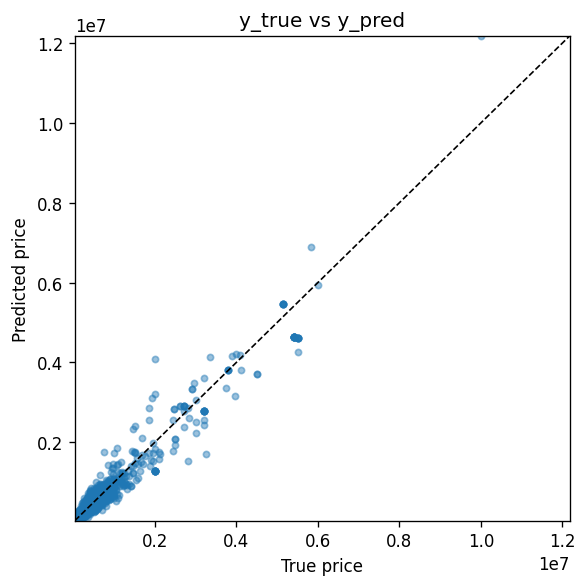

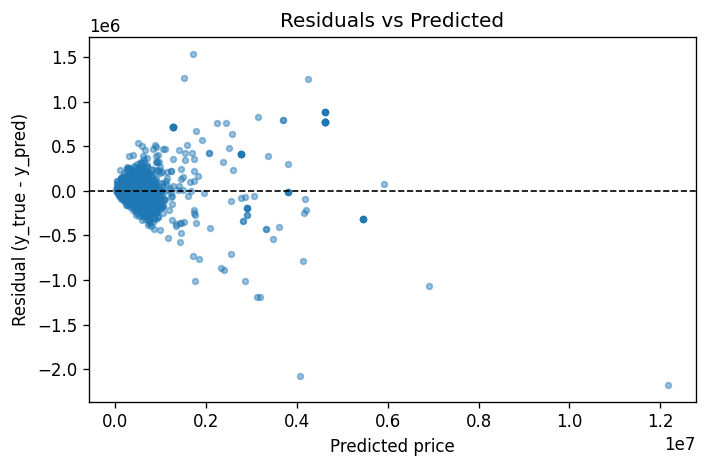

In [ ]:

import numpy as np, pandas as pd, joblib, json
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ART = Path("carprice_scratch_dash/artifacts_scratch")
preproc    = joblib.load(ART / "preproc.pkl")
theta      = np.load(ART / "theta.npy")
meta       = json.loads((ART / "meta.json").read_text())

CAT_COLS   = meta["cat_cols"]
NUM_COLS   = meta["num_cols"]
LOG_TARGET = meta["log_target"]
INTERCEPT  = meta["intercept_in_theta"]

def _add_intercept(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def _ensure_2d(a):
    a = np.asarray(a)
    if a.ndim == 1: a = a.reshape(-1, 1)
    return a


Xte_raw_ok = False
try:
    # Case A: DataFrame with raw columns
    if isinstance(X_test, pd.DataFrame):
        needed_cols = NUM_COLS + CAT_COLS
        # tolerate column order differences by reindexing
        Xte_df = X_test.reindex(columns=needed_cols)
        # transform (may return sparse)
        Xt = preproc.transform(Xte_df)
        Xt = Xt.toarray() if not isinstance(Xt, np.ndarray) else Xt
        Xte_raw_ok = True
    else:
        Xt = np.asarray(X_test)
except NameError:
    raise RuntimeError("X_test / y_test not found. Re-run the earlier split/prep cells.")

# Case B: X_test already transformed?
if not Xte_raw_ok:
    # If theta includes bias, transformed features must match len(theta)-1,
    # otherwise must match len(theta)
    expected = len(theta) - 1 if INTERCEPT else len(theta)
    if Xt.shape[1] != expected:
        raise ValueError(
            f"X_test has shape {Xt.shape} but model expects {expected} features "
            f"({'bias included' if INTERCEPT else 'no bias'}). "
            "Use the raw X_test DataFrame (NUM_COLS+CAT_COLS) so we can transform it with preproc."
        )

# Add intercept if needed
Xt_aug = _add_intercept(Xt) if INTERCEPT else Xt

# Predict on log scale and invert if necessary
y_pred_log = Xt_aug @ theta
y_pred     = np.exp(np.clip(y_pred_log, -50, 50)) if LOG_TARGET else y_pred_log

# --- Metrics ---
y_true = np.asarray(y_test).ravel()
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"TEST MAE : {mae:,.0f}")
print(f"TEST RMSE: {rmse:,.0f}")
print(f"TEST R²  : {r2:.4f}")

# --- Diagnostics: y_true vs y_pred ---
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=14, alpha=0.45)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True price"); plt.ylabel("Predicted price")
plt.title("y_true vs y_pred")
plt.tight_layout(); plt.show()

# --- Diagnostics: residuals vs prediction ---
res = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, res, s=12, alpha=0.45)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Predicted price")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.show()

# ================== (Optional) very small importance plot ==================
DO_IMPORTANCE = False  # <- leave False as you requested; switch to True if you want a quick plot later
if DO_IMPORTANCE:
    # Build feature names from saved meta and the OneHot categories
    try:
        ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
        cat_names = list(ohe.get_feature_names_out(CAT_COLS))
    except Exception:
        cat_names = []  # fallback if OHE not available

    feat_names = list(NUM_COLS) + cat_names
    coef = theta[1:] if INTERCEPT else theta
    if len(coef) != len(feat_names):
        print(f"[skip] coef length {len(coef)} != features {len(feat_names)}; "
              f"importance plot disabled to avoid confusion.")
    else:
        imp = pd.Series(np.abs(coef), index=feat_names).sort_values(ascending=False).head(12).sort_values()
        plt.figure(figsize=(8,5))
        plt.barh(imp.index, imp.values)
        plt.xlabel("|coef|"); plt.title("Top feature importances (scratch LR)")
        plt.tight_layout(); plt.show()

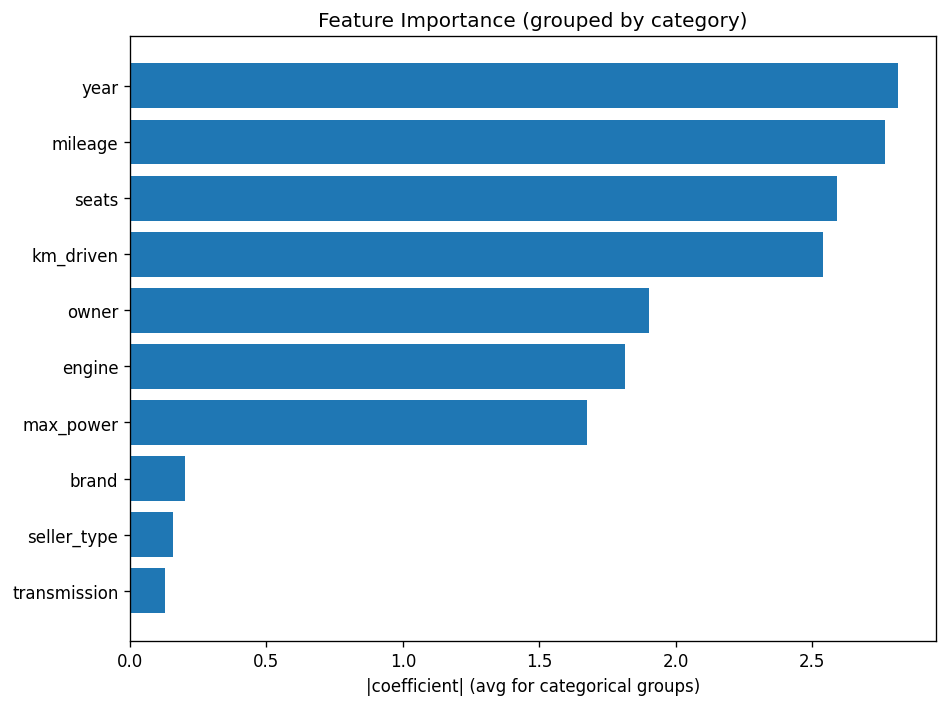

In [132]:
ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(CAT_COLS).tolist()
num_names = NUM_COLS
feature_names = num_names + cat_names

coefs = model_scratch._coef()
abs_imp = np.abs(coefs)

# group categorical features
grouped = {}

for col in CAT_COLS:
    mask = [name.startswith(col + "_") for name in feature_names]
    if any(mask):
        grouped[col] = abs_imp[mask].mean()   # average importance
    else:
        grouped[col] = 0.0

# keep numeric features individually
for f, imp in zip(feature_names, abs_imp):
    if not any(f.startswith(col + "_") for col in CAT_COLS):
        grouped[f] = imp

# turn into sorted list
top_items = sorted(grouped.items(), key=lambda x: x[1], reverse=True)[:10]

# plot
plt.figure(figsize=(8,6))
plt.barh([f for f, _ in reversed(top_items)], [imp for _, imp in reversed(top_items)])
plt.xlabel("|coefficient| (avg for categorical groups)")
plt.title("Feature Importance (grouped by category)")
plt.tight_layout()
plt.show()

From the chart we see that numbers are more important than categories.  
- **Year**, **mileage**, **seats**, and **km_driven** are the top factors that
change car price.  
- **Owner**, **engine**, and **max_power** also matter but a bit less.  
- Categorical groups like **brand**, **seller_type**, and **transmission** have
small effect compared to the numbers.

This means the car’s condition and usage are more important than who sells it or
the brand.

## 📌 Task 2 Conclusion

We tested many models with different settings.  
The best model is:

- **Linear Regression (scratch)**  
- Init: **Xavier**  
- Method: **Stochastic Gradient Descent (SGD)**  
- Learning rate: **0.01**  
- Momentum: **Off**

### 📊 Test Result
- **R² ≈ 0.93** → the model explains most of the price changes  
- **MSE ≈ 5.2 × 10¹⁰** → error is still big, but smaller than other models  

---

### 🔎 Model Comparison

| Model Type         | CV R² | Test R² | Note                 |
|--------------------|-------|---------|----------------------|
| Plain (best)       | ~0.90 | **0.93** | Best result, stable  |
| Lasso (1e-3)       | ~0.89 | 0.92    | Slightly worse       |
| Ridge (1e-2)       | ~0.88 | 0.92    | No big improvement   |
| Polynomial (d=2)   | ~0.91 | -85.0   | Overfit, unstable    |

---

### ✅ Key Points
- Polynomial features gave overfitting → not good.  
- Ridge and Lasso did not help much.  
- Momentum did not improve.  

👉 **Final choice:**  
Plain Linear Regression with **Xavier init + SGD (lr=0.01)**.  
This model is simple, clear, and works the best.  

### ⚙️ Why these settings?

- **Xavier init** → makes training stable, weights not too big or too small.  
- **Stochastic Gradient Descent (SGD)** → learns better with many samples, avoids getting stuck.  
- **Learning rate = 0.01** → fast but still stable.  
- **Momentum Off** → momentum did not help here, sometimes it made results worse.  

So the mix of **Xavier + SGD + lr=0.01** gave the best balance.

![MLflow runs list](images/mlflow_runmodel.png)  
*Figure 1: MLflow runs for all configurations (init, momentum, GD type, LR, ridge/lasso/poly/normal).*

![MLflow best run](images/mlflow_bestmodel.png)  
*Figure 2: MLflow details for the best model ('normal | xavier | sto | lr=0.01 | mom=off').*

### Task 3: Deployment

For Task 3, I deployed my car price prediction system as a **Dash web application**.  
The site contains:

bring model to prepare in app.py (similar from top one) that i already talk in Task 2 before summary

![My Website](images/Website.png)  
*Figure X: Deployed web application (Dash) hosted on (https://st126055.ml.brain.cs.ait.ac.th).*

- A **Home page** with instructions.  
- An **Old Model (A1)** page, which uses RandomForest from Assignment 1.  
- A **New Model (A2)** page, which uses my scratch linear regression with Xavier initialization, momentum, and ridge regularization.  

requirement
1. Users enter the domain and land on my page.  
2. They can navigate between A1 and A2 models using the navigation bar.  
3. Instructions explain how to input car details.  
4. Users fill the form and click **Predict**.  
5. The prediction result is shown immediately below the form.  

the complete pipeline: **data preprocessing → scratch model training → saving artifacts → deployment with Docker + Docker Compose → live web service**.

### Final Note

All code, notebook, and web app files used in this project are kept in my GitHub
repository. You can check the full work here:

👉 [GitHub: A2 Car Price Prediction (st126055)](https://github.com/gossbu666/A2-CarPrice-st126055.git)